In [1]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
import os
import math
import numpy as np
import pandas as pd

import quantstats

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12, 8) # (w, h)

from scipy.optimize import minimize

In [3]:
base_dir = os.path.join('C:/','workspace','project_quant')
note_dir = os.path.join(base_dir, 'note')
strategy_dir = os.path.join(base_dir, 'strategy')
index_data_dir = os.path.join(base_dir,'data','index_data')

In [7]:
np.random.seed(180)
data_prepared = False

start_date='2002-01-01'
end_date='2021-10-30'

In [14]:
def load_index_data(start_date, end_date, input_dir, input_excel_file_name, col_name):
    if input_excel_file_name[-4:]=='xlsx':
        input=pd.read_excel(os.path.join(input_dir,input_excel_file_name), index_col='Date')
        input=input.sort_index(ascending=False)
    elif input_excel_file_name[-4:]=='.csv':
        input=pd.read_csv(os.path.join(input_dir,input_excel_file_name), index_col='Date')
        input=input.sort_index(ascending=False)

    # input=input.drop(['CHG_PCT_1D'],axis=1)
    index_df=input.iloc[:,0].resample('1M').first().pct_change().fillna(0)
    index_df.rename(col_name, inplace=True)
    index_df=index_df.loc[start_date: end_date]
    return index_df

In [15]:
msci_world=load_index_data(start_date, end_date,index_data_dir, 'MSCI World.xlsx', 'msci_world')
msci_emerging=load_index_data(start_date, end_date,index_data_dir, 'MSCI Emerging.xlsx', 'msci_emerging')
msci_real_estate=load_index_data(start_date, end_date,index_data_dir, 'MSCI World Real Estate.xlsx', 'msci_real_estate')
snp_infra=load_index_data(start_date, end_date,index_data_dir, 'SNP GSCI TR.xlsx', 'snp_infra')
bb_short_treasury=load_index_data(start_date, end_date,index_data_dir,'Bloomberg Barclays US 1-3 month treasury.xlsx','bb_short_treasury')
bb_long_maturity=load_index_data(start_date, end_date,index_data_dir,'Bloomberg US 7-10 Treasury.xlsx','bb_long_maturity')
bb_corp_ig=load_index_data(start_date, end_date,index_data_dir,'Bloomberg Barclays US Corp IG.xlsx','bb_corp_ig')
bb_corp_hy=load_index_data(start_date, end_date,index_data_dir,'Bloomberg Barclays US Corp HY.xlsx','bb_corp_hy')
bb_infla_protect=load_index_data(start_date, end_date,index_data_dir,'Bloomberg Barclays US Inflation Protected.xlsx','bb_infla_protect')
snp_metal=load_index_data(start_date, end_date,index_data_dir,'SNP metal and mining.xlsx','snp_metal')
snp_oil=load_index_data(start_date, end_date,index_data_dir,'SNP oil gas exploration and production.xlsx','snp_oil')

return_df=pd.concat([msci_world,msci_emerging,msci_real_estate,snp_infra,bb_short_treasury,bb_long_maturity,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_metal,snp_oil], axis=1).fillna(0)
return_df

,msci_world,msci_emerging,msci_real_estate,snp_infra,bb_short_treasury,bb_long_maturity,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_metal,snp_oil
Date,,,,,,,,,,,
2002-01-31,0.016449,0.063876,0.022710,0.000774,-0.002436,-0.023532,-0.010831,-0.004277,-0.012717,0.050930,0.049673
2002-02-28,-0.035953,0.030178,-0.032724,-0.029901,0.006256,0.016165,0.013948,0.006756,0.008887,0.002242,-0.039237
2002-03-31,0.013737,0.029569,0.009666,0.039603,0.001255,0.001891,-0.000099,-0.014643,0.011282,0.026539,0.051396
2002-04-30,0.024798,0.040303,0.033943,0.129861,-0.004442,-0.022751,-0.013791,0.024335,-0.003210,0.107285,0.114534
2002-05-31,-0.029700,0.007080,0.058081,-0.019523,0.011479,0.029671,0.011728,0.015844,0.029441,-0.045188,0.014954
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,0.038195,0.002734,0.048829,0.075171,0.000970,0.007341,0.006059,0.010157,0.014751,0.053637,-0.030761
2021-06-30,0.011310,0.038808,0.026639,0.034986,0.000911,0.002301,0.004492,0.002682,0.010239,0.124030,0.143741
2021-07-31,0.015486,-0.016271,0.004921,0.034147,-0.001601,0.009949,0.017558,0.013973,0.005891,-0.091445,0.047279


In [16]:
cov_mat=pd.DataFrame(return_df.cov())
cov_mat

,msci_world,msci_emerging,msci_real_estate,snp_infra,bb_short_treasury,bb_long_maturity,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_metal,snp_oil
msci_world,0.002273,0.002537,0.002305,0.001754,-0.000021,-0.000298,0.000260,0.000999,0.000083,0.003856,0.003477
msci_emerging,0.002537,0.003868,0.002788,0.002312,-0.000007,-0.000314,0.000347,0.001215,0.000188,0.005069,0.004247
msci_real_estate,0.002305,0.002788,0.003195,0.001682,0.000008,-0.000144,0.000430,0.001176,0.000248,0.003976,0.003284
snp_infra,0.001754,0.002312,0.001682,0.004982,-0.000017,-0.000371,0.000190,0.000897,0.000209,0.004333,0.005043
bb_short_treasury,-0.000021,-0.000007,0.000008,-0.000017,0.000013,0.000046,0.000034,0.000005,0.000037,-0.000032,-0.000038
bb_long_maturity,-0.000298,-0.000314,-0.000144,-0.000371,0.000046,0.000328,0.000153,-0.000108,0.000200,-0.000717,-0.000695
bb_corp_ig,0.000260,0.000347,0.000430,0.000190,0.000034,0.000153,0.000271,0.000261,0.000181,0.000395,0.000421
bb_corp_hy,0.000999,0.001215,0.001176,0.000897,0.000005,-0.000108,0.000261,0.000738,0.000118,0.001891,0.001730
bb_infla_protect,0.000083,0.000188,0.000248,0.000209,0.000037,0.000200,0.000181,0.000118,0.000260,0.000169,0.000146
snp_metal,0.003856,0.005069,0.003976,0.004333,-0.000032,-0.000717,0.000395,0.001891,0.000169,0.011831,0.008459


In [33]:
def RiskParityObjective(x) :

    variance = np.dot(np.dot(x.T, cov_mat), x)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * np.dot(cov_mat, x)
    rc = x * mrc
    a = np.reshape(rc, (len(rc), 1))

    # 각 자산의 위험 기여도가 같도록
    # 아래쪽의 목적함수가 위험 기여도 차이의 제곱의 합이니 그것이 0에 가깝게 가야 함
    risk_diffs = a - a.T
    # np.ravel: 다차원 배열 -> 1차원 배열
    # 1차원으로 풀어준 후에 제곱 -> 합 -> 목적함수
    sum_risk_diffs_squared = np.sum(np.square(np.ravel(risk_diffs)))
    return (sum_risk_diffs_squared)

In [34]:
# 제약 조건: 비중 합 1
def SumConstraint(x):
    return (x.sum()-1.0)

# 제약 조건: 비중 0 이상
def LongOnly(x):
    return(x)

In [35]:
def RiskParity(covmat) :

    x0 = np.repeat(1/covmat.shape[1], covmat.shape[1])
    constraints = ({'type': 'eq', 'fun': SumConstraint},
                  {'type': 'ineq', 'fun': LongOnly})
    options = {'ftol': 1e-20, 'maxiter': 2000}

    result = minimize(fun = RiskParityObjective,
                      x0 = x0,
                      method = 'SLSQP',
                      constraints = constraints,
                      options = options)
    return(result.x)

In [37]:
weight_rp=RiskParity(cov_mat)

In [39]:
def RiskContribution(weight, covariance_matrix) :
    weight = np.array(weight)
    variance = np.dot(np.dot(weight.T, covariance_matrix) ,weight)
    sigma = np.sqrt(variance)
    mrc = 1/sigma * np.dot(covariance_matrix, weight)

    rc = weight * mrc
    rc = rc / rc.sum()
    return(rc)

In [40]:
weight_equal = np.repeat(1/return_df.shape[1], return_df.shape[1])
rc_equal = RiskContribution(weight_equal, cov_mat)
rc_equal

array([ 1.02451749e-01,  1.32324833e-01,  1.12691271e-01,  1.24968158e-01,
        1.61038796e-04, -1.14236879e-02,  1.75107545e-02,  5.30552857e-02,
        1.09235025e-02,  2.33312926e-01,  2.24024169e-01])

In [41]:
weight_rp=RiskParity(cov_mat)
rc_parity=RiskContribution(weight_rp, cov_mat)
rc_parity

array([0.09090909, 0.09090907, 0.09090908, 0.09090908, 0.09090922,
       0.09090907, 0.0909091 , 0.0909091 , 0.09090909, 0.09090905,
       0.09090905])

In [44]:
weight_6040=np.array([0.6,0.4])
cov_mat_6040=pd.DataFrame.cov(return_df[['msci_world','bb_long_maturity']])
rc_6040=RiskContribution(weight_6040, cov_mat_6040)
rc_6040

array([ 1.02601075, -0.02601075])

In [46]:
RP_Mon_12 = return_df
RP_Weight = []

for i in range(len(RP_Mon_12)):
    # use previous 12 months
    if i < 12:
        RP_Weight.append('')
    else:
        cov_mat = pd.DataFrame.cov(RP_Mon_12.iloc[i-12 : i-1])
        temp = []
        temp.append(RiskParity(cov_mat))
        RP_Weight.append(temp)

RP_Mon_12['RP_Weight'] = RP_Weight
RP_Mon_12=RP_Mon_12.loc['2003-01-31':]

In [47]:
RP_Return = []
ret = 0
for i in range(len(RP_Mon_12)):
    # 자산군 수익률 * 자산군 비중. 9개 자산군
    for j in range(9):
        ret += RP_Mon_12.iloc[i,j]*RP_Mon_12['RP_Weight'][i][0][j]

    RP_Return.append(ret)
    ret = 0

RP_Mon_12['RP_Return'] = RP_Return
RP_Mon_12

,msci_world,msci_emerging,msci_real_estate,snp_infra,bb_short_treasury,bb_long_maturity,bb_corp_ig,bb_corp_hy,bb_infla_protect,snp_metal,snp_oil,RP_Weight,RP_Return
Date,,,,,,,,,,,,,
2003-01-31,-0.047550,-0.040142,-0.029980,0.098477,0.007911,0.019927,0.019065,0.013679,0.024101,0.014006,0.051911,"[[0.027887664802192163, 0.02633273967994195, 0...",0.009755
2003-02-28,-0.022292,-0.001061,-0.022009,0.055763,0.004179,0.005718,0.014489,0.033187,0.015886,-0.097094,-0.042768,"[[0.02553438638445803, 0.02000693606667693, 0....",0.006331
2003-03-31,-0.028197,-0.024770,0.003232,0.099802,0.005774,0.025155,0.022277,0.012647,0.038594,-0.060943,0.025484,"[[0.03141280763570959, 0.023215220864348893, 0...",0.011597
2003-04-30,0.005221,-0.038643,-0.044744,-0.139184,0.001850,-0.007185,-0.001280,0.030030,-0.015867,-0.052125,0.014839,"[[0.03149222550132872, 0.023562150540639402, 0...",-0.006483
2003-05-31,0.077064,0.079040,0.031102,-0.039819,0.004074,0.002962,0.020383,0.056979,-0.000778,0.091646,-0.007563,"[[0.029635192917078668, 0.022369970137407512, ...",0.008960
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,0.038195,0.002734,0.048829,0.075171,0.000970,0.007341,0.006059,0.010157,0.014751,0.053637,-0.030761,"[[0.016988463757891623, 0.023477225172197393, ...",0.008494
2021-06-30,0.011310,0.038808,0.026639,0.034986,0.000911,0.002301,0.004492,0.002682,0.010239,0.124030,0.143741,"[[0.015015054014878628, 0.0184222364568273, 0....",0.004080
2021-07-31,0.015486,-0.016271,0.004921,0.034147,-0.001601,0.009949,0.017558,0.013973,0.005891,-0.091445,0.047279,"[[0.011631158555156161, 0.01258102801848281, 0...",0.001504


In [49]:
quantstats.stats.sharpe(RP_Mon_12['RP_Return'])/math.sqrt(252/12)

1.0136092438997393

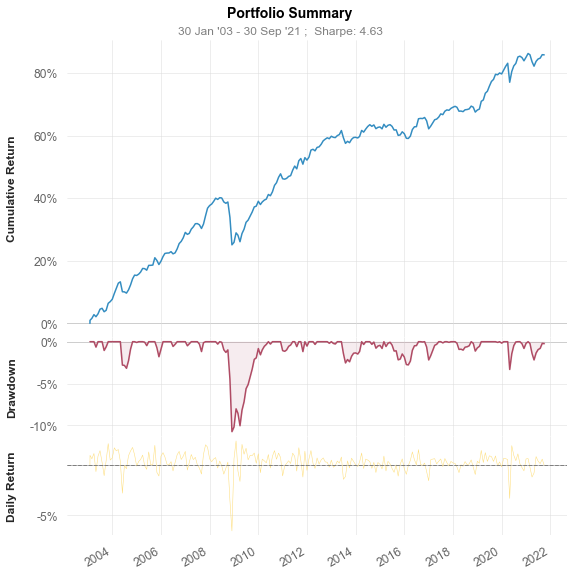

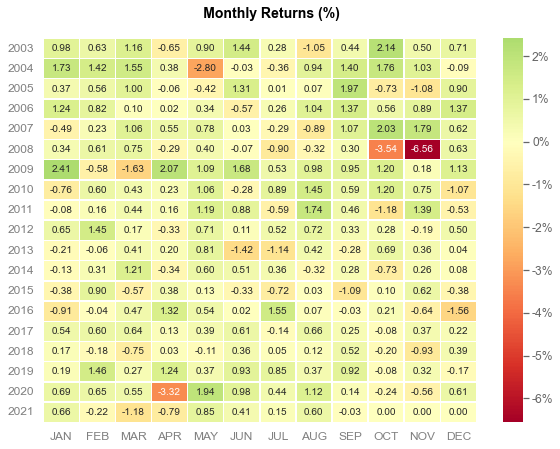

In [50]:
quantstats.reports.plots(RP_Mon_12['RP_Return'], mode='basic')

In [51]:
quantstats.reports.metrics(RP_Mon_12['RP_Return'], mode='full')

                           Strategy
-------------------------  ----------
Start Period               2003-01-31
End Period                 2021-09-30
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          85.77%
CAGR﹪                     3.37%

Sharpe                     4.64
Smart Sharpe               3.93
Sortino                    6.62
Smart Sortino              5.6
Sortino/√2                 4.68
Smart Sortino/√2           3.96
Omega                      2.3

Max Drawdown               -10.75%
Longest DD Days            700
Volatility (ann.)          15.21%
Calmar                     0.31
Skew                       -2.17
Kurtosis                   12.55

Expected Daily %           0.28%
Expected Monthly %         0.28%
Expected Yearly %          3.31%
Kelly Criterion            39.64%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.3%
Expected Shortfall (cVaR)  -1.3%

Gain/Pain Ratio            1.3
Gain/Pain (1M)             1.3
